In [2]:
import pandas as pd
import numpy as np
import re
from collections import Counter
import matplotlib.pyplot as plt

df = pd.read_csv("../data/TeleAntiFraud/cleaned_conversations.csv")

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9487 entries, 0 to 9486
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   conversation_id  9487 non-null   object
 1   label            9487 non-null   object
 2   left_text        9487 non-null   object
 3   right_text       9487 non-null   object
 4   full_text        9487 non-null   object
 5   fraud_type       3498 non-null   object
 6   perp_text_en     3029 non-null   object
dtypes: object(7)
memory usage: 518.9+ KB


In [6]:
df['perp_text_en'].isnull().sum()

np.int64(6458)

In [8]:
df['fraud_type'].value_counts()

fraud_type
Loan Scam             2124
Investment Scam        688
Telecom Scam           457
Impersonation Scam     209
Other Scam              16
Lottery/Prize Scam       4
Name: count, dtype: int64

In [12]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

TEXT_COL = "perp_text_en"
LABEL_COL = "fraud_type"
TOP_K = 2              # how many bigrams to print per scam type
MIN_DF = 1              # keep all bigrams (raise if you want to drop ultra-rare ones)
STOPWORDS = "english"   # set to None to keep all words

def print_top_bigrams_per_label(df, text_col=TEXT_COL, label_col=LABEL_COL,
                                top_k=TOP_K, min_df=MIN_DF, stopwords=STOPWORDS):
    df = df.copy()
    df[text_col] = df[text_col].fillna("").astype(str).str.strip()
    df = df[df[text_col].ne("") & df[label_col].notna()]
    if df.empty:
        print("No valid rows after cleaning.")
        return

    vect = CountVectorizer(
        lowercase=True,
        stop_words=stopwords,
        ngram_range=(2, 2),
        min_df=min_df,
        token_pattern=r"(?u)\b[\w']+\b"
    )
    X = vect.fit_transform(df[text_col])
    bigrams = np.array(vect.get_feature_names_out())

    for label, idx in df.groupby(label_col).indices.items():
        counts = np.asarray(X[idx].sum(axis=0)).ravel()
        if counts.sum() == 0:
            print(f"\n=== {label} ===\n(no bigrams after preprocessing)")
            continue
        k = min(top_k, (counts > 0).sum())
        top_idx = counts.argsort()[::-1][:k]
        print(f"\n=== {label} ===")
        for bg, c in zip(bigrams[top_idx], counts[top_idx]):
            print(f"{bg}: {int(c)}")

# --- USAGE ---
# df = pd.read_csv("your_file.csv")  # must include 'perp_text_en' and 'fraud_type'
print_top_bigrams_per_label(df)



=== Impersonation Scam ===
customer service: 273
click link: 166

=== Investment Scam ===
hello hello: 412
financial management: 311

=== Loan Scam ===
hello hello: 1286
click link: 982

=== Lottery/Prize Scam ===
click link: 4
send link: 3

=== Other Scam ===
hello hello: 11
click link: 7

=== Telecom Scam ===
customer service: 494
click link: 288


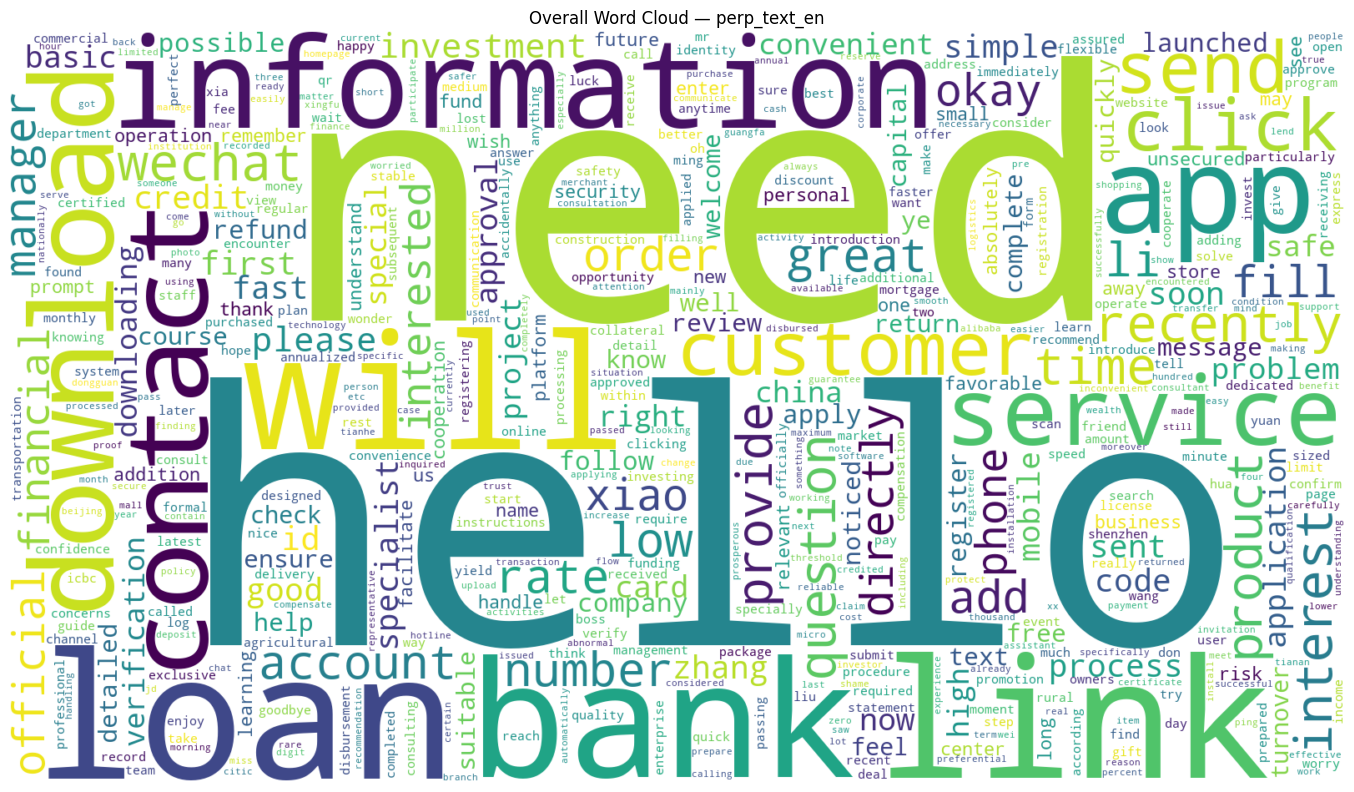

In [14]:
# pip install wordcloud matplotlib pandas
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# ---------- CONFIG ----------
CSV_PATH = "your_file.csv"     # change if needed
TEXT_COL = "perp_text_en"
EXTRA_STOPWORDS = {
    "rt","via","http","https","amp","im","dont","didnt","doesnt","wont","cant",
    "thats","ive","youre","weve","ill","u","ur","ok"
}
MIN_TOKEN_LEN = 2

# ---------- LOAD ----------
texts = df[TEXT_COL].dropna().astype(str)

# ---------- BASIC CLEAN ----------
def clean_text(s: str) -> str:
    s = s.lower()
    s = re.sub(r"https?://\S+|www\.\S+", " ", s)         # URLs
    s = re.sub(r"@\w+|#\w+", " ", s)                     # @mentions, #hashtags
    s = re.sub(r"&[a-z]+;", " ", s)                      # HTML entities like &amp;
    s = re.sub(r"[^a-z0-9'\s]", " ", s)                  # keep letters/digits/' and spaces
    s = re.sub(r"\s+", " ", s).strip()
    return s

cleaned = texts.map(clean_text)

# ---------- TOKEN FILTER + STOPWORDS ----------
stop = set(STOPWORDS) | EXTRA_STOPWORDS
def keep_token(tok: str) -> bool:
    if len(tok) < MIN_TOKEN_LEN:
        return False
    if tok in stop:
        return False
    # drop pure numbers
    if tok.isdigit():
        return False
    return True

filtered_docs = []
for line in cleaned:
    toks = [t for t in line.split() if keep_token(t)]
    filtered_docs.append(" ".join(toks))

full_text = " ".join(filtered_docs)

# ---------- WORDCLOUD ----------
wc = WordCloud(
    width=1600,
    height=900,
    background_color="white",
    stopwords=stop,
    max_words=500,
    collocations=False,   # avoid duplicate bigram emphasis; set True to allow bigram boosting
    prefer_horizontal=0.95
).generate(full_text)

plt.figure(figsize=(14, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title("Overall Word Cloud — perp_text_en")
plt.tight_layout()
plt.show()


In [17]:
# pip install umap-learn sentence-transformers
from sentence_transformers import SentenceTransformer
import umap.umap_ as umap
import matplotlib.pyplot as plt

texts = df[TEXT].fillna("").astype(str).tolist()
labels = df[LABEL].astype(str).tolist()
model = SentenceTransformer("all-MiniLM-L6-v2")
emb = model.encode(texts, normalize_embeddings=True, batch_size=256, show_progress_bar=False)
proj = umap.UMAP(n_neighbors=15, min_dist=0.1, metric="cosine", random_state=0).fit_transform(emb)
plt.figure(figsize=(8,6))
for c in pd.unique(labels):
    m = [i for i,l in enumerate(labels) if l==c]
    plt.scatter(proj[m,0], proj[m,1], s=6, label=c, alpha=0.7)
plt.legend(markerscale=3, bbox_to_anchor=(1.02,1), loc="upper left"); plt.title("UMAP of text embeddings"); plt.tight_layout(); plt.show()


c:\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ModuleNotFoundError: No module named 'umap'

     -------------------------------------- 488.0/488.0 kB 5.1 MB/s eta 0:00:00
